載入必要套件與類別

In [2]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from grid_backtest import trade
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

網格交易參數設定

In [3]:
# 金融商品設定
symbol = '0050' 
# 設定初始部位(%數)
init_ratio = 50
# 設定網格間距
grid_gap = round(0.025, 2)
# 設定交易單位(%數)
grid_unit = 5
# 初始部位是幾個交易單位
if init_ratio % grid_unit != 0:
    print('錯誤！初始部位要可以被交易單位整除')
init_unit = int(init_ratio / grid_unit)
# 上漲跟下跌網格差距比率
up_down_grid_gap_diff = 2

網格交易策略演算法

In [4]:
# 取得要回測的歷史資料
data = yf.download(f'{symbol}.TW')
data1 = data.replace(0, None)
data = data1.ffill()
data.columns = [i.lower() for i in data.columns]

# 期初買入張數
init_time = data.index[0]
init_price = data.loc[data.index[0], 'open']
trade_position = trade(init_time, init_price, init_unit)

# 依照迴圈來跑網格
for index, row in data.iterrows():
    # 優先執行比較差的狀況(賣出) 至少不會回測過度優化導致結果失真
    while row['open'] >= init_price * (1+grid_gap*up_down_grid_gap_diff):
        init_price *= (1+grid_gap*up_down_grid_gap_diff)
        trade_position.cover(index, row['open'])
    while row['high'] >= init_price * (1+grid_gap*up_down_grid_gap_diff):
        init_price *= (1+grid_gap*up_down_grid_gap_diff)
        trade_position.cover(index, init_price)
    # 再考慮(買進)的情況
    while row['open'] <= init_price * (1-grid_gap):
        init_price *= (1-grid_gap)
        if trade_position.position() < 100/grid_unit:
            trade_position.order(index, row['open'])
    while row['low'] <= init_price * (1-grid_gap):
        init_price *= (1-grid_gap)
        if trade_position.position() < 100/grid_unit:
            trade_position.order(index, init_price)

# 最後一天的資料 要把所有部位先出場 檢查總績效
while trade_position.position() > 0:
    trade_position.cover(index, row['close'])


[*********************100%%**********************]  1 of 1 completed
C:\Users\User\AppData\Local\Temp\ipykernel_8320\968277446.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data1.ffill()


In [5]:
# 還原除權息
trade_position.restoreReturn(symbol)
# 檢查進出紀錄
trade_position.position_table

d:\pythonProject\台股網格自動化交易書\grid_backtest.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dividend_table_one["西元日期"] = pd.to_datetime(
d:\pythonProject\台股網格自動化交易書\grid_backtest.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.position_table.loc[index, "還原除權息"] += row1["權值+息值"]


,進場時間,進場價格,出場時間,出場價格,買進後持有,還原除權息
0,2008-01-02,60.009998,2008-01-15 00:00:00,60.2,NaN,0.0
1,2008-01-02,60.009998,2008-02-19 00:00:00,58.0,NaN,0.0
2,2008-01-02,60.009998,2008-03-06 00:00:00,62.3,NaN,0.0
3,2008-01-02,60.009998,2008-03-21 00:00:00,61.4,NaN,0.0
4,2008-01-02,60.009998,2008-05-15 00:00:00,65.0,NaN,0.0
...,...,...,...,...,...,...
190,2022-12-08,114.000000,2024-06-12 00:00:00,176.0,18.0,7.5
191,2022-12-20,110.500000,2024-06-12 00:00:00,176.0,19.0,7.5
192,2023-07-07,127.500000,2024-06-12 00:00:00,176.0,17.0,4.9
193,2023-08-17,123.500000,2024-06-12 00:00:00,176.0,18.0,3.0


In [6]:
# 報酬率計算
position_table = trade_position.position_table
position_table['單筆報酬'] = (position_table['出場價格'] - position_table['進場價格'] +
                          position_table['還原除權息'])
position_table['單筆報酬率'] = position_table['單筆報酬'] / \
    position_table['進場價格'] * (grid_unit/100)
total_return = (position_table['單筆報酬率']).sum() + 1
print(f'總報酬率:{round(total_return-1,4)}')
yearly_return = total_return ** (1/(data.shape[0]/252))-1
print(f'年化報酬率:{round(yearly_return,4)}')

總報酬率:2.0966
年化報酬率:0.0731


<Axes: >

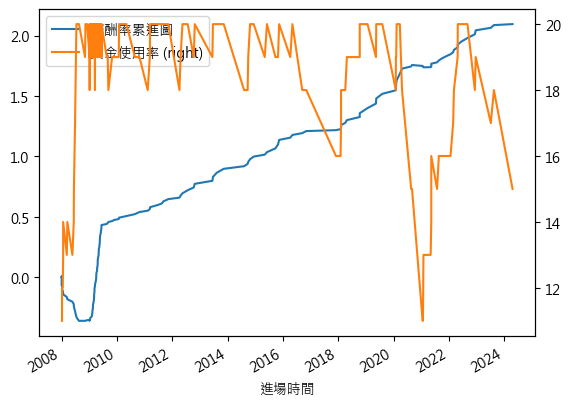

In [7]:
# 繪製報酬率圖
(position_table.set_index('進場時間')['單筆報酬率']).cumsum().plot(label='報酬率累進圖',legend=True)
(position_table.set_index('進場時間')['買進後持有']).plot(label='資金使用率',legend=True,secondary_y=True)

d:\pythonProject\台股網格自動化交易書\.venv\lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


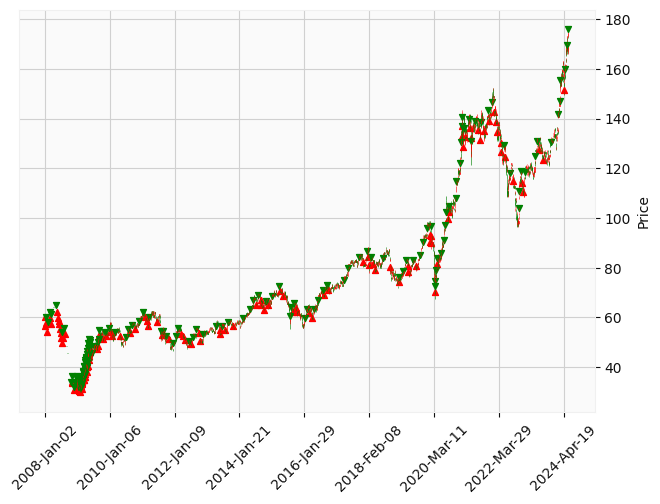

: 

In [8]:
# 繪製K線圖與下單點位
addp = []
data1 = pd.concat(
    [data, position_table.groupby('進場時間')['進場價格'].first()], axis=1)
data1 = pd.concat([data1, position_table.set_index('出場時間')[
                  '出場價格'].groupby('出場時間').first()], axis=1)
addp.append(mpf.make_addplot(data1['進場價格'],
                             scatter=True,
                             marker='^',
                             color='r'))
addp.append(mpf.make_addplot(data1['出場價格'],
                             scatter=True,
                             marker='v',
                             color='g'))
mcolor = mpf.make_marketcolors(up='red', down='green', inherit=True)
mstyle = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mcolor)
mpf.plot(data, type='candle', addplot=addp,
         style=mstyle, warn_too_much_data=999999)